In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
df = pd.read_csv('../data/cardio_train.csv', sep=';') # sep=';' is used to separate the data by semicolon
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


# Understand the data:
- age: by days
- gender:
  - 1: women
  - 2: men
- ap_hi (Systolic blood pressure):
  - Normal: 90-119
  - Elevated: 120–139 
  - High: 140 or higher
    - The interval of ap_hi should span somewhere between 90 and 140, give or take.
- ap_lo (Diastolic blood pressure):
  - Normal: 60-79
  - Elevated: 80-89
  - High: 90 or higher
    - The interval of ap_lo should span somewhere between 60 and 90, give or take.
  - resources: https://www.cdc.gov/bloodpressure/about.htm
- cholesterol:
  - 1: normal
  - 2: above normal
  - 3: well above normal
- gluc (glucose):
  - 1: normal
  - 2: above normal
  - 3: well above normal
- smoke:
  - 0: non-smoker
  - 1: smoker
- alco (alcohol intake):
  - 0: non-drinker
  - 1: drinker
- active (physical activity):
  - 0: inactive
  - 1: active
- cardio (cardiovascular disease):
  - 0: negative
  - 1: positive

In [73]:
df.info() # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [74]:
df.shape 

(70000, 13)

In [75]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


## a) Count the positive and negative cases for heart disease:

In [76]:
# get the count for cardio disease and no cardio disease
cardio_counts = df['cardio'].value_counts() # 0: 35021, 1: 34979

print(f'Negative cases: {cardio_counts[0]}\nPositive cases: {cardio_counts[1]}')

Negative cases: 35021
Positive cases: 34979


## b) Calculate the proportion of normal, above normal, and far above normal cholesterol levels and plot a pie chart:

In [77]:
# get the count for cholesterol
cholesterol_counts = df["cholesterol"].value_counts()

# divide the counts by the total number of rows to get the proportions
cholesterol_proportions = cholesterol_counts / len(df)

print(
    f"Normal cholesterol: {cholesterol_proportions[1]:.1%}\nAbove normal cholesterol: {cholesterol_proportions[2]:.1%}\nWell above normal cholesterol: {cholesterol_proportions[3]:.1%}"
)

Normal cholesterol: 74.8%
Above normal cholesterol: 13.6%
Well above normal cholesterol: 11.5%


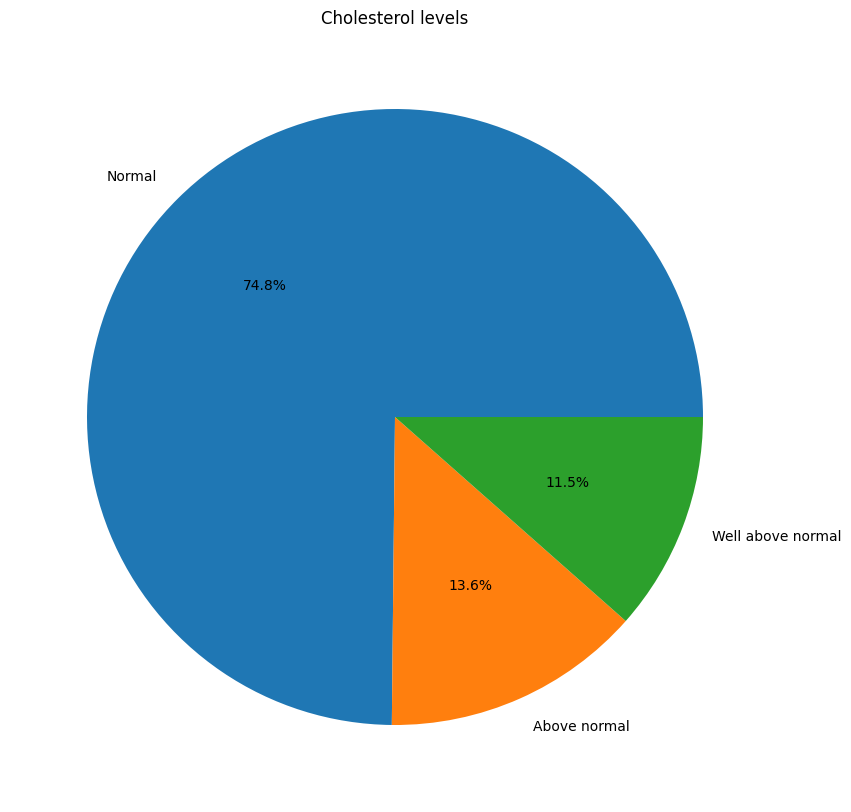

In [78]:
# pie chart for cholesterol levels

labels = ['Normal', 'Above normal', 'Well above normal'] 
plt.figure(figsize=(10, 10))
plt.pie(cholesterol_counts, labels=labels, autopct='%1.1f%%') # autopct is used to display the percentage
plt.title('Cholesterol levels')
plt.show()

## c) What does the age distribution look like? Draw a histogram.

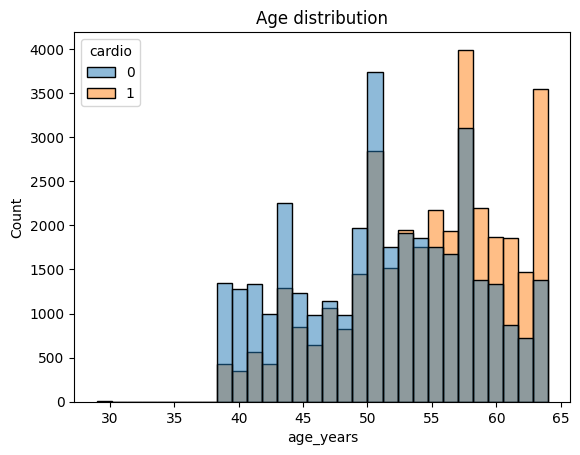

In [79]:
df['age_years'] = df['age'] // 365 # convert age from days to years, // is used to get the integer value

# Plot the age distribution
sns.histplot(data=df, x='age_years', hue='cardio', bins=30)
plt.title('Age distribution')
plt.show()

We notice that the positive cases for cardiovascular disease rises dramatically after the age of 54.

In [80]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47


## d) What proportion of the dataset are smokers?

In [81]:
# get the count for smokers and non-smokers
smoker_counts = df['smoke'].value_counts()

# divide the counts by the total number of rows to get the proportions
smoker_proportions = smoker_counts / len(df)

print(f"Non-smokers: {smoker_proportions[0]:.1%}\nSmokers: {smoker_proportions[1]:.1%}")

Non-smokers: 91.2%
Smokers: 8.8%


## e) What does the weight distribution look like? Draw an appropriate chart.

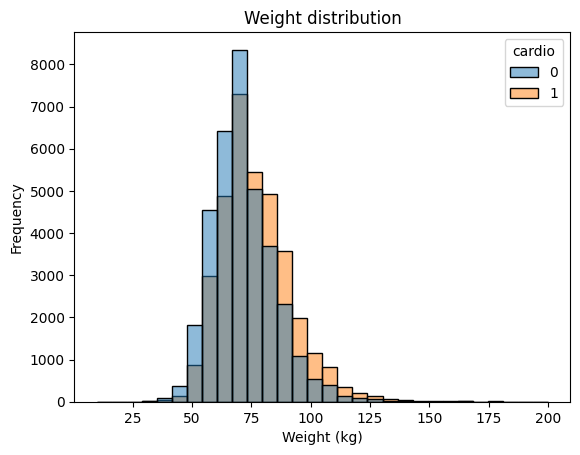

In [82]:
sns.histplot(data=df, x='weight', hue='cardio', bins=30)
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.title('Weight distribution')
plt.show()

## f) What does the height distribution look like? Draw an appropriate chart.

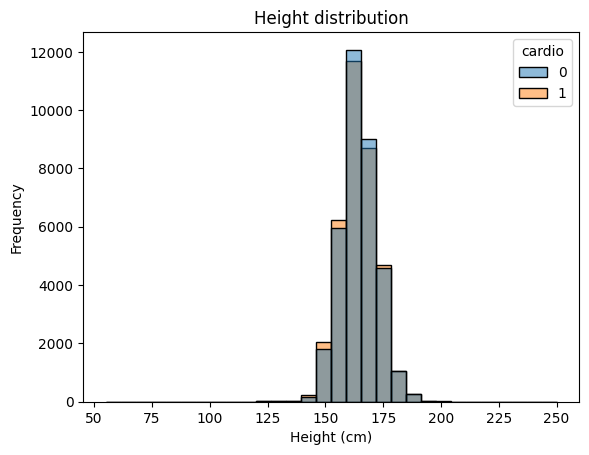

In [83]:
sns.histplot(data=df, x='height', hue='cardio', bins=30)
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.title('Height distribution')
plt.show()

## g) What proportion of women and men have cardiovascular disease? Draw an appropriate chart.

In [84]:
# Calculate the proportion of women and men with cardiovascular disease
gender_cardio_proportion = df.groupby('gender')['cardio'].mean()

print(f"Proportion of women with cardiovascular disease: {gender_cardio_proportion[1]:.4f}")
print(f"Proportion of men with cardiovascular disease: {gender_cardio_proportion[2]:.4f}")

Proportion of women with cardiovascular disease: 0.4967
Proportion of men with cardiovascular disease: 0.5052


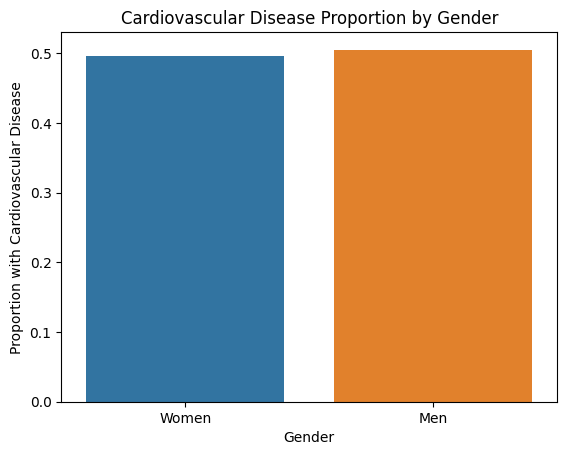

In [85]:
sns.barplot(x=['Women', 'Men'], y=gender_cardio_proportion.values)
plt.xlabel('Gender')
plt.ylabel('Proportion with Cardiovascular Disease')
plt.title('Cardiovascular Disease Proportion by Gender')
plt.show()

# 2.1.0 - Feature engineering BMI

## Create a BMI feature (Body Mass Index) using the formula:
    - BMI = weight (kg) / height (m) ^ 2

In [86]:
# calculate BMI 

df['BMI'] = df['weight'] / ((df['height'] / 100) ** 2) # we divide the height by 100 to convert it from cm to m
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,23.011177


## a) Remove samples with unreasonable BMI values and outliers:

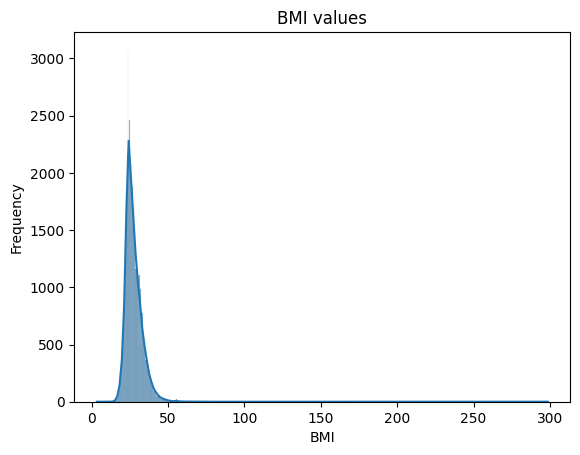

In [87]:
sns.histplot(data=df, x='BMI', kde=True) 
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('BMI values')
plt.show()

In [88]:
df['BMI'].describe()

count    70000.000000
mean        27.556513
std          6.091511
min          3.471784
25%         23.875115
50%         26.374068
75%         30.222222
max        298.666667
Name: BMI, dtype: float64

The minimum BMI in the dataset is around 3.5 and the maximum is 298.6:
- the lowest BMI that I could find on the internet is around 13
  - https://www.bbc.com/news/uk-england-leeds-44488822
----
- the highest BMI that I could find on the internet is around 105
  - https://en.wikipedia.org/wiki/Jon_Brower_Minnoch

In [89]:
lower_threshold = 13
upper_threshold = 105

# Filter the dataset based on the specified BMI thresholds
filtered_df = df[(df['BMI'] >= lower_threshold) & (df['BMI'] <= upper_threshold)]
filtered_df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,52,26.927438
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1,61,50.472681
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,52,31.353579
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,61,27.099251


## b) Create a categorical BMI feature with the categories: normal range, overweight, obese (class I), obese (class II), obese (class III):

In [90]:
# a function to categorize the BMI values

def bmi_category(bmi):
    if 18.5 <= bmi < 25:
        return 'Normal range'
    elif 25 <= bmi < 30:
        return 'Overweight'
    elif 30 <= bmi < 35:
        return 'Obese (Class I)'
    elif 35 <= bmi < 40:
        return 'Obese (Class II)'
    else:
        return 'Obese (Class III)'

In [91]:
# apply the .copy() method, otherwise I was getting a SettingWithCopyWarning
filtered_df = filtered_df.copy()

# Apply the function to the BMI column to create a new categorical column
filtered_df["bmi_category"] = filtered_df["BMI"].apply(bmi_category) # the apply() method is used to apply a function to a column
filtered_df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI,bmi_category
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,Normal range
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,Obese (Class I)
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,Normal range
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,Overweight
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,23.011177,Normal range


# 2.1.1 - Feature engineering blood pressure

## Remove samples with unreasonable blood pressure values and outliers:

In [92]:
df['ap_hi'].describe()

count    70000.000000
mean       128.817286
std        154.011419
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

In [93]:
df['ap_lo'].describe()

count    70000.000000
mean        96.630414
std        188.472530
min        -70.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      11000.000000
Name: ap_lo, dtype: float64

Negative blood pressure values are not possible and the maximum blood pressure cannot be at 16000 for ap_hi and 11000 for ap_lo. So I will have to investigate what is the highest and lowest blood pressure values ever recorded.
- the highest blood pressure that I could find on the internet is 370/360 (ap_hi/ap_lo)
  - https://www.bbc.com/news/uk-england-leeds-44488822
----
- there are mixed reports on the lowest blood pressure ever recorded, but to a chart i found on this website: https://www.theemtspot.com/blood-pressure/readings/60-40/. It could go as low as 50/30 (ap_hi/ap_lo). So i'm going to assume that this is the lowest.

In [94]:
lower_threshold_ap_hi = 50
upper_threshold_ap_hi = 370
lower_threshold_ap_lo = 30
upper_threshold_ap_lo = 360

filtered_df = filtered_df[
    (filtered_df["ap_hi"] >= lower_threshold_ap_hi)
    & (filtered_df["ap_hi"] <= upper_threshold_ap_hi)
    & (filtered_df["ap_lo"] >= lower_threshold_ap_lo)
    & (filtered_df["ap_lo"] <= upper_threshold_ap_lo)
]

filtered_df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI,bmi_category
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,Normal range
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,Obese (Class I)
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,Normal range
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,Overweight
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,23.011177,Normal range
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,52,26.927438,Overweight
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1,61,50.472681,Obese (Class III)
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,52,31.353579,Obese (Class I)
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,61,27.099251,Overweight


## Create a categorical blood pressure feature with the categories: Healthy, Elevated, Stage 1 Hypertension, Stage 2 Hypertension, Hypertensive Crisis:
- Healthy: < 120/80
- Elevated: 120-129/80
- Stage 1 Hypertension: 130-139/80-89
- Stage 2 Hypertension: >= 140/90
- Stage 3 Hypertension: > 180/120
  - source: https://www.healthline.com/health/high-blood-pressure-hypertension#definition

In [95]:
def blood_pressure_category(ap_hi, ap_lo):
    if ap_hi < 120 and ap_lo < 80:
        return 'Healthy'
    elif 120 <= ap_hi < 130 and ap_lo < 80:
        return 'Elevated'
    elif 130 <= ap_hi < 140 or (80 <= ap_lo < 90):
        return 'Stage 1 Hypertension'
    elif 140 <= ap_hi < 180 or (90 <= ap_lo < 120):
        return 'Stage 2 Hypertension'
    else:
        return 'Stage 3 Hypertension'

In [96]:
# Apply the function to the ap_hi and ap_lo columns to create a new categorical column
filtered_df["bp_category"] = filtered_df.apply( # Create a new 'bp_category' column
    lambda row: blood_pressure_category(row["ap_hi"], row["ap_lo"]), axis=1) # Apply the 'blood_pressure_category' function to each row of the DataFrame
filtered_df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI,bmi_category,bp_category
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,Normal range,Stage 1 Hypertension
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,Obese (Class I),Stage 2 Hypertension
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,Normal range,Stage 1 Hypertension
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,Overweight,Stage 2 Hypertension
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,23.011177,Normal range,Healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,52,26.927438,Overweight,Stage 1 Hypertension
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1,61,50.472681,Obese (Class III),Stage 2 Hypertension
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,52,31.353579,Obese (Class I),Stage 2 Hypertension
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,61,27.099251,Overweight,Stage 1 Hypertension


## 2.2.0 - Visualization of disease proportions

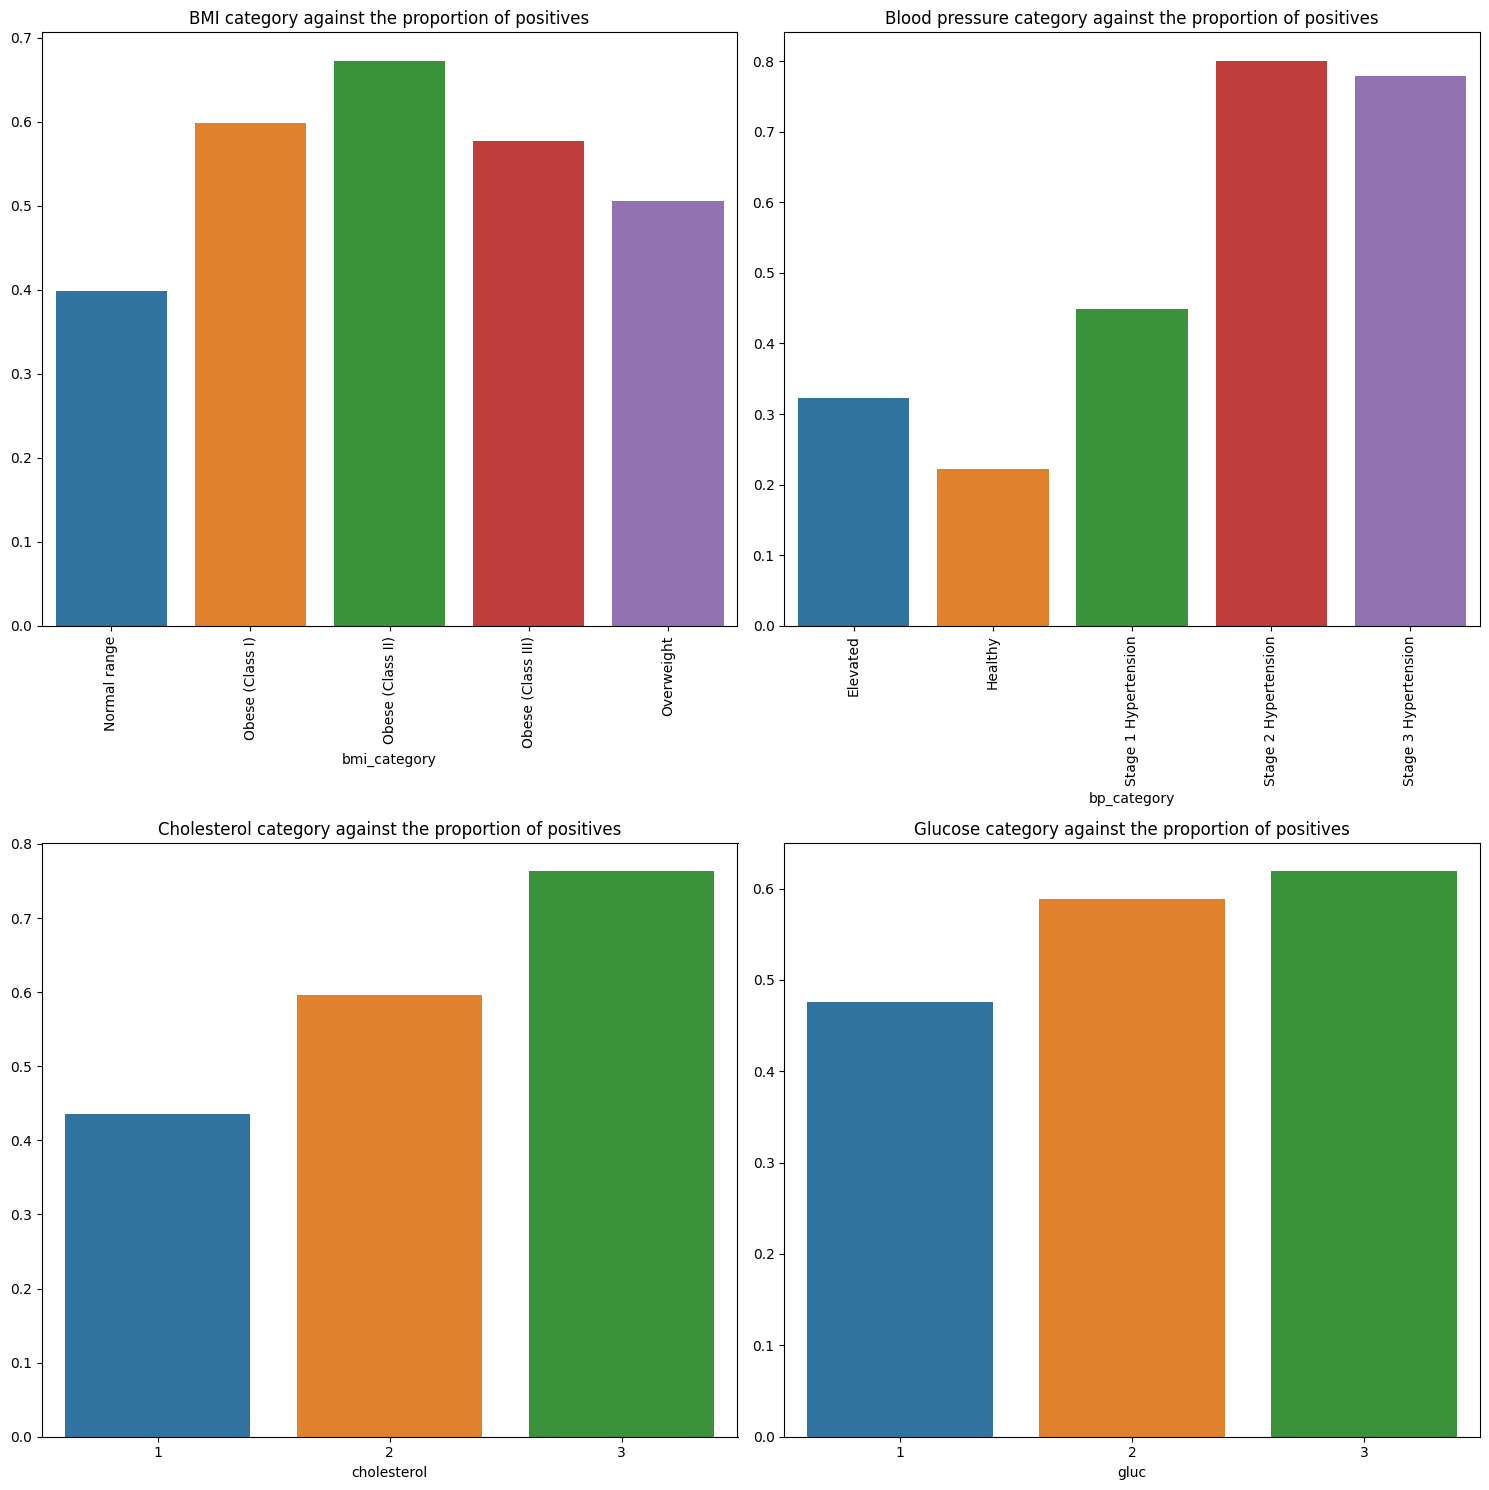

In [97]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# group by the bmi_category column and calculate the mean of the cardio column in order to get the proportion
bmi_proportions = filtered_df.groupby('bmi_category')['cardio'].mean() 
# we plot on the x-axis the bmi_category column and on the y-axis the proportion of cardio
sns.barplot(x=bmi_proportions.index, y=bmi_proportions.values, ax=axes[0, 0])
# rotate the x-axis labels to make them more readable
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=90)

bp_proportions = filtered_df.groupby('bp_category')['cardio'].mean()
sns.barplot(x=bp_proportions.index, y=bp_proportions.values, ax=axes[0, 1])
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=90) 

cholesterol_proportions = filtered_df.groupby('cholesterol')['cardio'].mean()
sns.barplot(x=cholesterol_proportions.index, y=cholesterol_proportions.values, ax=axes[1, 0])

gluc_proportions = filtered_df.groupby('gluc')['cardio'].mean()
sns.barplot(x=gluc_proportions.index, y=gluc_proportions.values, ax=axes[1, 1])

axes[0, 0].set_title('BMI category against the proportion of positives')
axes[0, 1].set_title('Blood pressure category against the proportion of positives')
axes[1, 0].set_title('Cholesterol category against the proportion of positives')
axes[1, 1].set_title('Glucose category against the proportion of positives')

plt.tight_layout() # this method is used to adjust the spacing between subplots
plt.show() 

## 2.2.1 - Visualizations correlation

In [98]:
filtered_df.corr()

C:\Users\hadda\AppData\Local\Temp\ipykernel_21784\3374119047.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  filtered_df.corr()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
id,1.000000,0.003591,0.003042,-0.003285,-0.001793,0.001320,-0.000614,0.005951,0.002349,-0.003320,0.000686,0.003884,0.003789,0.003905,-0.000438
age,0.003591,1.000000,-0.023177,-0.084310,0.055327,0.208710,0.152521,0.155512,0.099241,-0.047814,-0.028980,-0.010606,0.239606,0.999092,0.101571
gender,0.003042,-0.023177,1.000000,0.511135,0.156906,0.061315,0.066500,-0.036696,-0.021163,0.338800,0.171068,0.005894,0.007249,-0.023309,-0.109039
height,-0.003285,-0.084310,0.511135,1.000000,0.305744,0.019508,0.036634,-0.052848,-0.020229,0.193137,0.097217,-0.008962,-0.011760,-0.084281,-0.221570
weight,-0.001793,0.055327,0.156906,0.305744,1.000000,0.268846,0.248561,0.141470,0.106961,0.066845,0.068236,-0.017844,0.180117,0.055178,0.852697
ap_hi,0.001320,0.208710,0.061315,0.019508,0.268846,1.000000,0.696874,0.193953,0.092507,0.027076,0.032423,-0.001336,0.425132,0.208331,0.261927
ap_lo,-0.000614,0.152521,0.066500,0.036634,0.248561,0.696874,1.000000,0.158550,0.076327,0.024775,0.043407,0.000064,0.334620,0.152303,0.232811
cholesterol,0.005951,0.155512,-0.036696,-0.052848,0.141470,0.193953,0.158550,1.000000,0.451262,0.009946,0.035803,0.009013,0.221478,0.155124,0.169326
gluc,0.002349,0.099241,-0.021163,-0.020229,0.106961,0.092507,0.076327,0.451262,1.000000,-0.005691,0.011263,-0.007529,0.090036,0.098931,0.117763
smoke,-0.003320,-0.047814,0.338800,0.193137,0.066845,0.027076,0.024775,0.009946,-0.005691,1.000000,0.339803,0.025362,-0.016295,-0.047814,-0.033900


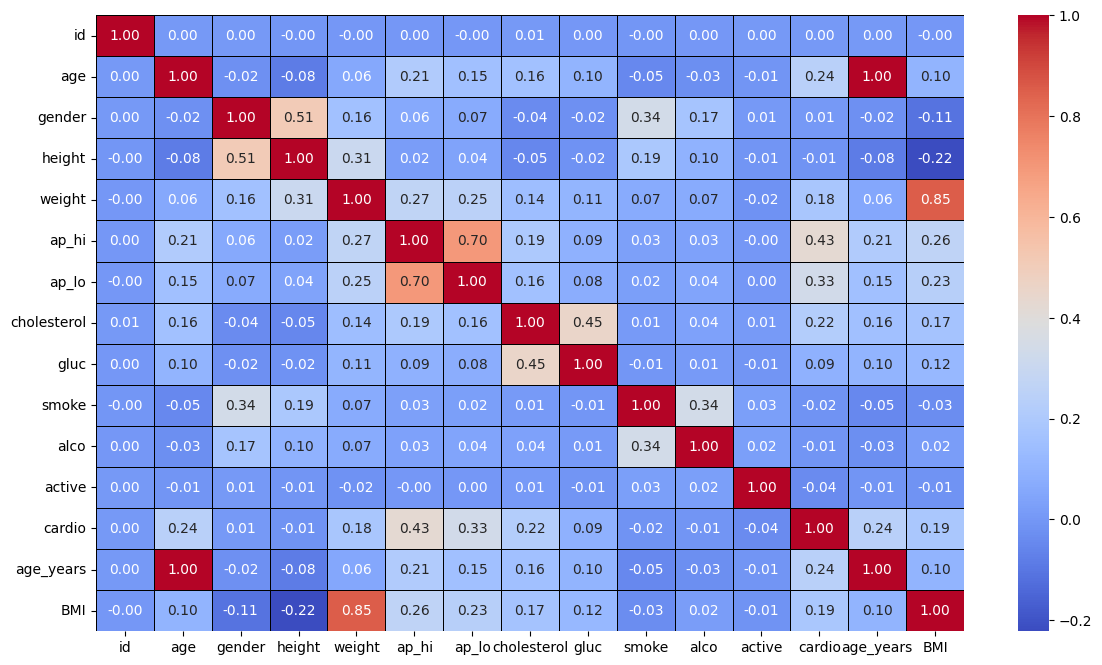

In [99]:
plt.figure(figsize=(14, 8))
sns.heatmap(
    filtered_df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, linecolor="black"
)  # numeric_only=True to silence the warning - fmt='.2f' to display the correlation values with 2 decimal places
plt.show()

## 2.3 - Create two datasets:
- Create a copy of the filtered DataFrame.
- Drop the specified columns from each DataFrame.
- Perform dummy encoding on the specified columns.

In [100]:
# Create a copy of the filtered DataFrame
df1 = filtered_df.copy()

# Drop the specified columns
df1.drop(['ap_hi', 'ap_lo', 'height', 'weight', 'BMI'], axis=1, inplace=True)

# Perform dummy encoding on the specified columns
df1 = pd.get_dummies(df1, columns=['bmi_category', 'bp_category', 'gender'])
df1.head()

,id,age,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi_category_Normal range,...,bmi_category_Obese (Class II),bmi_category_Obese (Class III),bmi_category_Overweight,bp_category_Elevated,bp_category_Healthy,bp_category_Stage 1 Hypertension,bp_category_Stage 2 Hypertension,bp_category_Stage 3 Hypertension,gender_1,gender_2
0,0,18393,1,1,0,0,1,0,50,1,...,0,0,0,0,0,1,0,0,0,1
1,1,20228,3,1,0,0,1,1,55,0,...,0,0,0,0,0,0,1,0,1,0
2,2,18857,3,1,0,0,0,1,51,1,...,0,0,0,0,0,1,0,0,1,0
3,3,17623,1,1,0,0,1,1,48,0,...,0,0,1,0,0,0,1,0,0,1
4,4,17474,1,1,0,0,0,0,47,1,...,0,0,0,0,1,0,0,0,1,0


In [101]:
# Create a copy of the filtered DataFrame
df2 = filtered_df.copy()

# Drop the specified columns
df2.drop(['bmi_category', 'bp_category', 'height', 'weight'], axis=1, inplace=True)

# Perform dummy encoding on the specified column
df2 = pd.get_dummies(df2, columns=['gender'])
df2.head()

,id,age,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI,gender_1,gender_2
0,0,18393,110,80,1,1,0,0,1,0,50,21.967120,0,1
1,1,20228,140,90,3,1,0,0,1,1,55,34.927679,1,0
2,2,18857,130,70,3,1,0,0,0,1,51,23.507805,1,0
3,3,17623,150,100,1,1,0,0,1,1,48,28.710479,0,1
4,4,17474,100,60,1,1,0,0,0,0,47,23.011177,1,0


## 2.4 - Choose three models:
- Logistic Regression
- Decision Tree
- Random Forest

## Split the data:

In [102]:
from sklearn.model_selection import train_test_split

X1 = df1.drop('cardio', axis=1) # features
y1 = df1['cardio'] # target

X2 = df2.drop('cardio', axis=1)
y2 = df2['cardio'] 

display(X1.head(), y1.head(), X2.head(), y2.head())

,id,age,cholesterol,gluc,smoke,alco,active,age_years,bmi_category_Normal range,bmi_category_Obese (Class I),bmi_category_Obese (Class II),bmi_category_Obese (Class III),bmi_category_Overweight,bp_category_Elevated,bp_category_Healthy,bp_category_Stage 1 Hypertension,bp_category_Stage 2 Hypertension,bp_category_Stage 3 Hypertension,gender_1,gender_2
0,0,18393,1,1,0,0,1,50,1,0,0,0,0,0,0,1,0,0,0,1
1,1,20228,3,1,0,0,1,55,0,1,0,0,0,0,0,0,1,0,1,0
2,2,18857,3,1,0,0,0,51,1,0,0,0,0,0,0,1,0,0,1,0
3,3,17623,1,1,0,0,1,48,0,0,0,0,1,0,0,0,1,0,0,1
4,4,17474,1,1,0,0,0,47,1,0,0,0,0,0,1,0,0,0,1,0


0    0
1    1
2    1
3    1
4    0
Name: cardio, dtype: int64

,id,age,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,BMI,gender_1,gender_2
0,0,18393,110,80,1,1,0,0,1,50,21.967120,0,1
1,1,20228,140,90,3,1,0,0,1,55,34.927679,1,0
2,2,18857,130,70,3,1,0,0,0,51,23.507805,1,0
3,3,17623,150,100,1,1,0,0,1,48,28.710479,0,1
4,4,17474,100,60,1,1,0,0,0,47,23.011177,1,0


0    0
1    1
2    1
3    1
4    0
Name: cardio, dtype: int64

In [103]:
# train|validation|test split for df1
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train, y1_train, test_size=0.2, random_state=42)

# train|validation|test split for df2
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train, y2_train, test_size=0.2, random_state=42)

## Standardization and normalization:

In [104]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Feature standardization for df1
scaler_standard = StandardScaler()
X1_train_standard = scaler_standard.fit_transform(X1_train)
X1_val_standard = scaler_standard.transform(X1_val)
X1_test_standard = scaler_standard.transform(X1_test)

# Feature normalization for df1
scaler_normalized = MinMaxScaler()
X1_train_normalized = scaler_normalized.fit_transform(X1_train)
X1_val_normalized = scaler_normalized.transform(X1_val)
X1_test_normalized = scaler_normalized.transform(X1_test)

X1

In [ ]:
# Feature standardization for df2
scaler_standard = StandardScaler()
X2_train_standard = scaler_standard.fit_transform(X2_train)
X2_val_standard = scaler_standard.transform(X2_val)
X2_test_standard = scaler_standard.transform(X2_test)

# Feature normalization for df2
scaler_normalized = MinMaxScaler()
X2_train_normalized = scaler_normalized.fit_transform(X2_train)
X2_val_normalized = scaler_normalized.transform(X2_val)
X2_test_normalized = scaler_normalized.transform(X2_test)

## Define the hyperparameters:

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Hyperparameters for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}

# Hyperparameters for Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}

# Hyperparameters for Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
